In [1]:
__updated__ = '2021-12-28 21:30:56'
import warnings
warnings.filterwarnings("ignore")

from Calculator import Calculator as Calc
# from PlotTools import createPlot
from utils import (
    pd, np, getSchema, getDateBeforeTrade, 
    saveRecommand, timedelta, GetException,
    sendResultTable, VolumeFilter, PriceFilter,
    changedType, datetime
)
import os
parent = os.path.dirname(os.path.abspath("__file__"))
output_path = os.path.join(parent, 'StrongResearch', 'CrossDayTrade_v3')
if not os.path.isdir(output_path):
    os.makedirs(output_path)
    


c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
def getLimit(price, pct=0.1, trend="U"):
    tmp_price = price
    if trend == "U":
        while 1:
            tick = Calc.get_minimum_tick(tmp_price)
            tmp_price += tick
            if (tmp_price/price) > 1 + pct:
                tmp_price -= tick
                break
    elif trend == "D":
        while 1:
            tick = Calc.get_minimum_tick(tmp_price)
            tmp_price -= tick
            if (tmp_price/price) < 1 - pct:
                tmp_price += tick
                break
            
    return round(tmp_price, 2)

In [30]:
def BacktestCrossDayTradeV3(td= datetime.today(), tp_ratio=.02, sl_ratio=.05):
    try:
        if td.isocalendar()[-1] > 5:
            tdStr = td.strftime("%Y-%m-%d")
            print(f"It\'s Holiday {tdStr}")
            return
        td, last = getDateBeforeTrade(td.replace(hour=18))
        pre_1y = td + timedelta(-365)
        tdStr = td.strftime("%Y-%m-%d")
        print(f"=============Start Backtest {tdStr}==================")
        # setup data
        schema = getSchema('TWSE')
        table = schema['StockList']
        last_date = sorted(table.distinct("UpdateDate"))[-1]
        info_data = dict((x['Ticker'], x['Industry']+f"({x['Market'][-1]})") for x in table.find({"UpdateDate":{"$eq":last_date}, "Industry" :{"$ne":""}}))

        schema = getSchema('TWSE')
        table = schema['historicalPrice']
        
        test_data = list(table.find({'Date':{'$gte':td.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$eq":"2330"}}))
        if not test_data:
            print(f"It\'s Holiday {tdStr}")
            return
        data = list(table.find({'Date':{'$gte':last.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$in":list(info_data.keys())}}))
        df = pd.DataFrame(data)
        if len(df.Date.unique()) <= 1:
            data = list(table.find({'Date':{'$gte':(td+timedelta(-30)).strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$in":list(info_data.keys())}}))
            df = pd.DataFrame(data)
            df = df[df.Date.isin(sorted(df.Date.unique())[-2:])]
            for col in 'Open,High,Low,Close,Volume'.split(','):
                df[col] = df[col].apply(changedType)
        
#         print("Start Stock Picking")
        StrongTickers = []
        for ticker in list(info_data.keys()):
            try:
#                 print("Check", ticker)
                temp_data = list(table.find({'Date':{'$gte':pre_1y.strftime('%Y-%m-%d'), '$lte':last.strftime('%Y-%m-%d')}, "Ticker" :{"$eq":ticker}}))
                temp_df = pd.DataFrame(temp_data)
                for col in 'Open,High,Low,Close,Volume'.split(','):
                    temp_df[col] = temp_df[col].apply(changedType)
                temp_df['Close'] = temp_df['Close'].fillna(method='ffill')
                if np.isnan(temp_df.Close.iloc[-4]):
                    continue
                temp_df = Calc.MA(temp_df, [5, 10, 20, 60])
#                 print(temp_df.Close.iloc[-4])
                uplimit = getLimit(temp_df.Close.iloc[-4], .1)
#                 dnlimit = getLimit(temp_df.Close.iloc[-], sl_ratio, trend="D")
                
                last_2_bar = temp_df.Close.iloc[-2] < temp_df.Open.iloc[-2]
                last_1_bar = temp_df.Close.iloc[-1] < temp_df.Open.iloc[-1]
                long_trend = temp_df.MA5.iloc[-1] > temp_df.MA10.iloc[-1] and temp_df.MA10.iloc[-1] > temp_df.MA20.iloc[-1] and temp_df.MA20.iloc[-1] > temp_df.MA60.iloc[-1]
                test_ma5 = temp_df.Close.iloc[-1] > temp_df.MA5.iloc[-1] and temp_df.Close.iloc[-2] > temp_df.MA5.iloc[-2] and temp_df.Close.iloc[-3] > temp_df.MA5.iloc[-3]
                slope_60 = temp_df.MA60.iloc[-1] > temp_df.MA60.iloc[-2]
                if temp_df.Close.iloc[-3] >= uplimit and last_2_bar and last_1_bar and long_trend and test_ma5 and slope_60:
#                     print("Check", ticker)
#                 if temp_df.High.iloc[-1] >= uplimit and temp_df.Volume.iloc[-2] / 1000 >= 1000: #  and temp_df['LowRet'].iloc[-1] > -.05
                    StrongTickers.append(ticker)
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except KeyError:
                pass
            except:
                print(GetException())
                pass
#         print(td, StrongTickers)
        with open(os.path.join(output_path, f'{td.strftime("%Y%m%d")}_StrongTicker.csv'), 'w', encoding='utf-8') as f:
            for ticker in StrongTickers:
                f.writelines(ticker + '\n')
#         for ticker in StrongTickers:
#             tmp_df = df[df.Ticker == ticker]
#             entry_ = tmp_df.Close.iloc[-2]
            
        selected = StrongTickers
#         selected = []
#         for ticker in list(info_data.keys()):
#         #     print(ticker)
#             try:
#                 tmp_data = list(table.find({'Date':{'$gte':pre_1y.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$eq":ticker}}))

#                 tmp_df = pd.DataFrame(tmp_data)
#                 for col in 'Open,High,Low,Close,Volume'.split(','):
#                     tmp_df[col] = tmp_df[col].apply(changedType)

#                 tmp_df = Calc.MA(tmp_df, [5,10,20])
#                 tmp_df['Adj V'] = tmp_df.Volume.apply(lambda x: int(x/1000))
#                 if tmp_df['Adj V'].iloc[-1] < 1000:
#                     continue
#                 tmp_df['VMA5'] = tmp_df['Adj V'].rolling(5).mean()
#                 tmp_df['VMA10'] = tmp_df['Adj V'].rolling(10).mean()
#                 tmp_df['VMA20'] = tmp_df['Adj V'].rolling(20).mean()

#                 tmp_df['VSlope5'] = tmp_df['VMA5'].pct_change()
#                 tmp_df['VSlope10'] = tmp_df['VMA10'].pct_change()
#                 tmp_df['VSlope20'] = tmp_df['VMA20'].pct_change()

#                 tmp_df['Slope5'] = tmp_df['MA5'].pct_change()
#                 tmp_df['Slope10'] = tmp_df['MA10'].pct_change()
#                 tmp_df['Slope20'] = tmp_df['MA20'].pct_change()
#                 tmp_df['HC'] = tmp_df['High'] / tmp_df['Close'].shift(1) - 1
#                 tmp_df['HCMA'] = tmp_df['HC'].rolling(5).mean()# >= .05
#                 v_slope_condi = tmp_df.VSlope10.iloc[-1] > 0 and tmp_df.VSlope20.iloc[-1] > 0 and tmp_df.VSlope5.iloc[-1] > 0
#                 p_slope_condi = tmp_df.Slope10.iloc[-1] > 0 and tmp_df.Slope20.iloc[-1] > 0
#                 tr_condi = tmp_df['HCMA'].iloc[-1] >= .05
#                 v_condi = min(tmp_df['VMA5'].iloc[-1], tmp_df['VMA20'].iloc[-1]) >= 5000
#                 p_condi = tmp_df.Close.iloc[-1] < 500
#                 pct_condi = tmp_df['Close'].pct_change().iloc[-1] >= .06
# #                 k_condi_1 = not ((tmp_df['Close'].iloc[-1] < tmp_df['Open'].iloc[-1] or tmp_df['Close'].pct_change().iloc[-1] < 0) and tmp_df['Adj V'].pct_change().iloc[-1] < 0)
# #                 k_condi_2 = not (tmp_df['Close'].iloc[-1] < tmp_df['Open'].iloc[-1] and round(tmp_df['Adj V'].pct_change().iloc[-1],2) >= 1)
# #                 k_condi = all([k_condi_1, k_condi_2])
#                 tmp_tick = Calc.get_minimum_tick(tmp_df.Close.iloc[-1])
#                 limit_condi = True
#                 if (tmp_df.Close.iloc[-1] + tmp_tick) / tmp_df.Close.iloc[-2] > 1.1:
#                     limit_condi = False
#                 if (tmp_df.Close.iloc[-1] - tmp_tick) / tmp_df.Close.iloc[-2] < 0.9:
#                     limit_condi = False
#                 if v_slope_condi and p_slope_condi and tr_condi and v_condi and p_condi and limit_condi and pct_condi: #  and k_condi
#                     selected.append(ticker)
#             except:
#                 pass
#         print(selected, len(selected), '\n')
        if selected:
#             ShowProfitable(selected, StrongTickers)
            CalculateBacktestResult(td, df, selected, StrongTickers, tp_ratio, sl_ratio)
        else:
            print("沒有符合條件的標的")
    except KeyboardInterrupt:
        raise KeyboardInterrupt
    except Exception as e:
        print(f"It\'s Holiday {tdStr}, {e}")
        print(GetException())
        pass

In [11]:
def ShowProfitable(selected, StrongTickers):
    profitable = list(set(selected).intersection(StrongTickers))
    unprofitable = list(set(selected).difference(StrongTickers))
    
    print('profitable',profitable, len(profitable))
    print('unprofitable',unprofitable, len(unprofitable))

def CalculateBacktestResult(td, df, selected, StrongTickers, tp_ratio=.02, sl_ratio=.05):
    try:
#         print(td, StrongTickers)
        with open(os.path.join(output_path, f'{td.strftime("%Y%m%d")}_ProfitLoss.csv'), 'w', encoding='utf-8') as f:
            f.writelines('Ticker,P/L,OpenRet,HighRet,LowRet,CloseRet,pnl\n')#,TakeProfit,StopLoss
            print('Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss\n')
            total_pnl = 0
            num_win = 0
            total_trade_value = 0
            for col in 'Open,High,Low,Close,Volume'.split(','):
                df[col] = df[col].apply(changedType)
            for ticker in StrongTickers:
                temp_df = df[df.Ticker==ticker]
#                 print(temp_df.Close.iloc[-2], type(temp_df.Close.iloc[-2]))
                uplimit = getLimit(temp_df.Close.iloc[-2], tp_ratio)
                upRet = (uplimit / temp_df.Close.iloc[-2] - 1) * 100
                dnlimit = getLimit(temp_df.Close.iloc[-2], sl_ratio, trend="D")
                dnRet = (dnlimit / temp_df.Close.iloc[-2] - 1) * 100

                temp_df['HighRet'] = (temp_df.High.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100
                temp_df['Ret'] = (temp_df.Close.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100
                temp_df['LowRet'] = (temp_df.Low.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100
                temp_df['OpenRet'] = (temp_df.Open.iloc[-1] / temp_df.Close.iloc[-2] - 1) * 100

                earning = 0
                exit = 0
                if temp_df['Open'].iloc[-1] >= uplimit:
                    exit = temp_df['Open'].iloc[-1]
                elif temp_df['Low'].iloc[-1] >= uplimit:
                    exit = temp_df['Low'].iloc[-1]
                elif temp_df['High'].iloc[-1] >= uplimit:
                    exit = uplimit
                if exit:
                    num_win += 1

                if not exit:
                    if temp_df['Open'].iloc[-1] <= dnlimit:
                        exit = temp_df['Open'].iloc[-1]
                    elif temp_df['High'].iloc[-1] <= dnlimit:
                        exit = temp_df['High'].iloc[-1]
                    elif temp_df['Low'].iloc[-1] <= dnlimit:
                        exit = dnlimit # temp_df.Close.iloc[-2] * (1 - .05)
                    else:
                        exit = temp_df['Close'].iloc[-1]
                print(f"{ticker}, take profit price :{uplimit}, stop loss price:{dnlimit}, entry : {temp_df.Close.iloc[-2]}. exit : {exit}")

                earning = int((exit - temp_df.Close.iloc[-2]) * 1000)
                earning -= round(temp_df.Close.iloc[-2] * 1.425)
                earning -= round(exit * 4.425)

                pnl = 'profit' if earning > 0 else 'loss'
                total_pnl += earning 
                total_trade_value += temp_df.Close.iloc[-2] * 1000
                text = f"{ticker},{pnl},{round(temp_df['OpenRet'].iloc[-1], 2)}%,{round(temp_df['HighRet'].iloc[-1], 2)}%,{round(temp_df['LowRet'].iloc[-1], 2)}%,{round(temp_df['Ret'].iloc[-1], 2)}%,{earning}\n"
    #             text = f"{ticker},{pnl},{round(temp_df['Open'].iloc[-1], 2)},{round(temp_df['High'].iloc[-1], 2)},{round(temp_df['Low'].iloc[-1], 2)},{round(temp_df['Close'].iloc[-1], 2)},{earning},{uplimit},{dnlimit}\n"
                f.writelines(text)
                text = f"股票={ticker},損/益={pnl},隔日開盤={temp_df['Open'].iloc[-1]},隔日最高={temp_df['High'].iloc[-1]},隔日收盤={temp_df['Close'].iloc[-1]},隔日最低={temp_df['Low'].iloc[-1]},損益金額={earning},漲停價={uplimit},跌停價={dnlimit}\n"
                print(text)
            total_ret = round((total_pnl / total_trade_value) * 100, 2)
            win_probability = round(num_win / len(selected)*100, 2)
            f.writelines(f"total,{win_probability}%,,,,{total_ret}%,{total_pnl},{total_trade_value}\n")
            print(f"total,勝率={win_probability}%,,,總報酬率={total_ret}%,,總損益={total_pnl},總交易金額={total_trade_value}\n")
    except Exception as e:
        print("CalculateBacktestResult, Error :",e)
        print(GetException())

In [31]:
# for date in pd.date_range(datetime(2021, 7, 1), datetime.today()):
# for date in pd.date_range(datetime(2018, 1, 2), datetime(2021,12,31)):# datetime(2020,12,31)
for date in pd.date_range(datetime(2021, 3, 11), datetime(2021,12,31)):# datetime(2020,12,31)
    try:
        BacktestCrossDayTradeV3(date, .02, .025)
    except KeyboardInterrupt:
        break

2021-03-11 18:00:00
=============Start Backtest 2021-03-11==================
2021-03-11 18:00:00 ['3066', '3354']
2021-03-11 18:00:00 ['3066', '3354']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

3066, take profit price :13.35, stop loss price:12.8, entry : 13.1. exit : 12.75
股票=3066,損/益=loss,隔日開盤=12.75,隔日最高=12.75,隔日收盤=12.15,隔日最低=12.0,損益金額=-424,漲停價=13.35,跌停價=12.8

3354, take profit price :15.1, stop loss price:14.5, entry : 14.85. exit : 15.0
股票=3354,損/益=profit,隔日開盤=15.05,隔日最高=15.05,隔日收盤=15.0,隔日最低=14.65,損益金額=63,漲停價=15.1,跌停價=14.5

total,勝率=0.0%,,,總報酬率=-1.29%,,總損益=-361,總交易金額=27950.0

2021-03-12 18:00:00
=============Start Backtest 2021-03-12==================
2021-03-12 18:00:00 ['1535', '2719', '3276', '4760', '5475']
2021-03-12 18:00:00 ['1535', '2719', '3276', '4760', '5475']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

1535, take profit price :38.75, stop loss price:37.05, entry : 38.0. exit : 38.75
股票=1535,損/益=profit,隔日開盤=38.25,隔日最高=39.35,隔日收盤=38.35,隔日最低=38.2,損

 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-03-24 18:00:00 ['2457', '3046', '3149', '6166', '6283', '4550']
2021-03-24 18:00:00 ['2457', '3046', '3149', '6166', '6283', '4550']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2457, take profit price :24.9, stop loss price:23.85, entry : 24.45. exit : 24.9
股票=2457,損/益=profit,隔日開盤=24.45,隔日最高=25.5,隔日收盤=25.3,隔日最低=24.0,損益金額=304,漲停價=24.9,跌停價=23.85

3046, take profit price :17.55, stop loss price:16.85, entry : 17.25. exit : 17.55
股票=3046,損/益=profit,隔日開盤=17.25,隔日最高=18.5,隔日收盤=18.1,隔日最低=17.2,損益金額=197,漲停價=17.55,跌停價=16.85

3149, take profit price :38.6, stop loss price:36.95, entry : 37.85. exit : 38.6
股票=3149,損/益=profit,隔日開盤=37.1,隔日最高=38.6,隔日收盤=37.05,隔日最低=36.5,損益金額=525,漲停價=38.6,跌停價=36.95

6166, take profit price :67.3, stop loss price:64.4, entry : 66.0. exit : 67.3
股票=6166,損/益=profit,隔日開盤=66.0,隔日最高=67.5,隔日收盤=65.0,隔日最低=64.9,損益金額=907,漲停價=67.3,跌停價=64

2021-04-08 18:00:00 ['1568', '3228', '4945']
2021-04-08 18:00:00 ['1568', '3228', '4945']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

1568, take profit price :35.95, stop loss price:34.4, entry : 35.25. exit : 35.95
股票=1568,損/益=profit,隔日開盤=35.3,隔日最高=37.8,隔日收盤=36.0,隔日最低=35.2,損益金額=491,漲停價=35.95,跌停價=34.4

3228, take profit price :563.0, stop loss price:539.0, entry : 552.0. exit : 563.0
股票=3228,損/益=profit,隔日開盤=555.0,隔日最高=564.0,隔日收盤=512.0,隔日最低=501.0,損益金額=7722,漲停價=563.0,跌停價=539.0

4945, take profit price :63.6, stop loss price:60.9, entry : 62.4. exit : 63.6
股票=4945,損/益=profit,隔日開盤=62.2,隔日最高=67.9,隔日收盤=65.0,隔日最低=61.8,損益金額=830,漲停價=63.6,跌停價=60.9

total,勝率=100.0%,,,總報酬率=1.39%,,總損益=9043,總交易金額=649650.0

2021-04-09 18:00:00
=============Start Backtest 2021-04-09==================
2021-04-09 18:00:00 ['3669', '6438', '6103', '8415']
2021-04-09 18:00:00 ['3669', '6438', '6103', '8415']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

3669, take profit price :92.9, stop loss price:

 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-04-14 18:00:00 ['3014', '3308', '5538', '8021', '8404', '3597', '6113']
2021-04-14 18:00:00 ['3014', '3308', '5538', '8021', '8404', '3597', '6113']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

3014, take profit price :118.5, stop loss price:114.0, entry : 116.5. exit : 118.5
股票=3014,損/益=profit,隔日開盤=118.0,隔日最高=120.0,隔日收盤=114.5,隔日最低=105.5,損益金額=1310,漲停價=118.5,跌停價=114.0

3308, take profit price :11.5, stop loss price:11.05, entry : 11.3. exit : 11.05
股票=3308,損/益=loss,隔日開盤=11.25,隔日最高=11.25,隔日收盤=10.35,隔日最低=10.2,損益金額=-315,漲停價=11.5,跌停價=11.05

5538, take profit price :41.1, stop loss price:39.3, entry : 40.3. exit : 39.65
股票=5538,損/益=loss,隔日開盤=39.95,隔日最高=40.1,隔日收盤=39.65,隔日最低=39.65,損益金額=-881,漲停價=41.1,跌停價=39.3

8021, take profit price :42.9, stop loss price:41.05, entry : 42.1. exit : 43.0
股票=8021,損/益=profit,隔日開盤=43.0,隔日最高=44.2,隔日收盤=41.6,隔日最低=39.75,損益

2021-04-21 18:00:00 ['2028', '2477', '6667']
2021-04-21 18:00:00 ['2028', '2477', '6667']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2028, take profit price :37.05, stop loss price:35.45, entry : 36.35. exit : 37.05
股票=2028,損/益=profit,隔日開盤=36.6,隔日最高=38.4,隔日收盤=37.4,隔日最低=36.5,損益金額=483,漲停價=37.05,跌停價=35.45

2477, take profit price :43.6, stop loss price:41.7, entry : 42.75. exit : 41.7
股票=2477,損/益=loss,隔日開盤=42.7,隔日最高=42.7,隔日收盤=41.55,隔日最低=41.15,損益金額=-1295,漲停價=43.6,跌停價=41.7

6667, take profit price :87.7, stop loss price:83.9, entry : 86.0. exit : 83.9
股票=6667,損/益=loss,隔日開盤=85.0,隔日最高=86.6,隔日收盤=84.0,隔日最低=83.5,損益金額=-2593,漲停價=87.7,跌停價=83.9

total,勝率=33.33%,,,總報酬率=-2.06%,,總損益=-3405,總交易金額=165100.0

2021-04-22 18:00:00
=============Start Backtest 2021-04-22==================
2021-04-22 18:00:00 ['1413', '2008', '2015', '2024', '2030', '2069', '5538', '5523']
2021-04-22 18:00:00 ['1413', '2008', '2015', '2024', '2030', '2069', '5538', '5523']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProf

 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-04-29 18:00:00 ['1474', '2239', '2603', '2606', '2615', '2617', '3033', '4967', '3260', '3402', '5245', '5864', '6679', '8088']
2021-04-29 18:00:00 ['1474', '2239', '2603', '2606', '2615', '2617', '3033', '4967', '3260', '3402', '5245', '5864', '6679', '8088']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

1474, take profit price :18.1, stop loss price:17.35, entry : 17.75. exit : 18.25
股票=1474,損/益=profit,隔日開盤=18.25,隔日最高=19.5,隔日收盤=18.05,隔日最低=18.0,損益金額=394,漲停價=18.1,跌停價=17.35

2239, take profit price :116.0, stop loss price:111.5, entry : 114.0. exit : 116.0
股票=2239,損/益=profit,隔日開盤=115.0,隔日最高=120.5,隔日收盤=115.0,隔日最低=114.0,損益金額=1325,漲停價=116.0,跌停價=111.5

2603, take profit price :78.3, stop loss price:74.9, entry : 76.8. exit : 78.3
股票=2603,損/益=profit,隔日開盤=77.8,隔日最高=79.0,隔日收盤=79.0,隔日最低=74.6,損益金額=1045,漲停價=78.3,跌停價=74.9

2606, take profit price :69.3, 

2021-05-12 18:00:00 ['9927', '3339']
2021-05-12 18:00:00 ['9927', '3339']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

9927, take profit price :33.85, stop loss price:32.4, entry : 33.2. exit : 33.85
股票=9927,損/益=profit,隔日開盤=33.0,隔日最高=34.2,隔日收盤=31.95,隔日最低=30.6,損益金額=452,漲停價=33.85,跌停價=32.4

3339, take profit price :18.6, stop loss price:17.8, entry : 18.25. exit : 18.85
股票=3339,損/益=profit,隔日開盤=18.85,隔日最高=19.05,隔日收盤=17.2,隔日最低=16.5,損益金額=491,漲停價=18.6,跌停價=17.8

total,勝率=100.0%,,,總報酬率=1.83%,,總損益=943,總交易金額=51450.0

2021-05-13 18:00:00
=============Start Backtest 2021-05-13==================
2021-05-13 18:00:00 []
沒有符合條件的標的
2021-05-14 18:00:00
=============Start Backtest 2021-05-14==================
2021-05-14 18:00:00 []
沒有符合條件的標的
It's Holiday 2021-05-15
It's Holiday 2021-05-16
2021-05-17 18:00:00
=============Start Backtest 2021-05-17==================
2021-05-17 18:00:00 []
沒有符合條件的標的
2021-05-18 18:00:00
=============Start Backtest 2021-05-18==================
2021-05-18 18:00:00 []

2021-06-09 18:00:00 ['1463', '1709', '1806']
2021-06-09 18:00:00 ['1463', '1709', '1806']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

1463, take profit price :17.45, stop loss price:16.75, entry : 17.15. exit : 17.45
股票=1463,損/益=profit,隔日開盤=17.05,隔日最高=17.45,隔日收盤=16.5,隔日最低=16.15,損益金額=199,漲停價=17.45,跌停價=16.75

1709, take profit price :22.05, stop loss price:21.15, entry : 21.65. exit : 21.15
股票=1709,損/益=loss,隔日開盤=21.45,隔日最高=21.5,隔日收盤=20.55,隔日最低=20.35,損益金額=-625,漲停價=22.05,跌停價=21.15

1806, take profit price :13.45, stop loss price:12.9, entry : 13.2. exit : 13.45
股票=1806,損/益=profit,隔日開盤=13.15,隔日最高=14.1,隔日收盤=13.3,隔日最低=12.65,損益金額=171,漲停價=13.45,跌停價=12.9

total,勝率=66.67%,,,總報酬率=-0.49%,,總損益=-255,總交易金額=52000.0

2021-06-10 18:00:00
=============Start Backtest 2021-06-10==================
2021-06-10 18:00:00 ['4402', '6570']
2021-06-10 18:00:00 ['4402', '6570']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

4402, take profit price :8.26, stop loss price:7.9, entry : 8.1. exit : 

2021-06-29 18:00:00 ['8367']
2021-06-29 18:00:00 ['8367']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

8367, take profit price :49.6, stop loss price:47.45, entry : 48.65. exit : 49.6
股票=8367,損/益=profit,隔日開盤=49.0,隔日最高=49.7,隔日收盤=45.9,隔日最低=45.6,損益金額=662,漲停價=49.6,跌停價=47.45

total,勝率=100.0%,,,總報酬率=1.36%,,總損益=662,總交易金額=48650.0

2021-06-30 18:00:00
=============Start Backtest 2021-06-30==================
2021-06-30 18:00:00 ['2481']
2021-06-30 18:00:00 ['2481']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2481, take profit price :80.2, stop loss price:76.8, entry : 78.7. exit : 80.5
股票=2481,損/益=profit,隔日開盤=80.5,隔日最高=86.4,隔日收盤=86.2,隔日最低=80.2,損益金額=1331,漲停價=80.2,跌停價=76.8

total,勝率=100.0%,,,總報酬率=1.69%,,總損益=1331,總交易金額=78700.0

2021-07-01 18:00:00
=============Start Backtest 2021-07-01==================
2021-07-01 18:00:00 ['2642', '3051', '5227']
2021-07-01 18:00:00 ['2642', '3051', '5227']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2642, take profit price :141.

2021-07-09 18:00:00 ['2476', '5608']
2021-07-09 18:00:00 ['2476', '5608']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2476, take profit price :50.35, stop loss price:48.25, entry : 49.45. exit : 50.35
股票=2476,損/益=profit,隔日開盤=48.3,隔日最高=54.2,隔日收盤=53.1,隔日最低=48.05,損益金額=606,漲停價=50.35,跌停價=48.25

5608, take profit price :69.6, stop loss price:66.6, entry : 68.3. exit : 69.6
股票=5608,損/益=profit,隔日開盤=67.5,隔日最高=70.7,隔日收盤=62.7,隔日最低=62.1,損益金額=894,漲停價=69.6,跌停價=66.6

total,勝率=100.0%,,,總報酬率=1.27%,,總損益=1500,總交易金額=117750.0

It's Holiday 2021-07-10
It's Holiday 2021-07-11
2021-07-12 18:00:00
=============Start Backtest 2021-07-12==================
2021-07-12 18:00:00 ['1460', '2705', '2712', '5706', '2734']
2021-07-12 18:00:00 ['1460', '2705', '2712', '5706', '2734']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

1460, take profit price :13.6, stop loss price:13.05, entry : 13.35. exit : 13.05
股票=1460,損/益=loss,隔日開盤=13.4,隔日最高=13.55,隔日收盤=13.0,隔日最低=12.95,損益金額=-376,漲停價=13.6,跌停價=13.05

27

2021-07-23 18:00:00 ['2491', '6594']
2021-07-23 18:00:00 ['2491', '6594']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2491, take profit price :35.25, stop loss price:33.75, entry : 34.6. exit : 35.5
股票=2491,損/益=profit,隔日開盤=35.5,隔日最高=38.05,隔日收盤=38.0,隔日最低=35.05,損益金額=693,漲停價=35.25,跌停價=33.75

6594, take profit price :55.0, stop loss price:52.7, entry : 54.0. exit : 55.0
股票=6594,損/益=profit,隔日開盤=54.1,隔日最高=59.3,隔日收盤=55.9,隔日最低=52.6,損益金額=680,漲停價=55.0,跌停價=52.7

total,勝率=100.0%,,,總報酬率=1.55%,,總損益=1373,總交易金額=88600.0

It's Holiday 2021-07-24
It's Holiday 2021-07-25
2021-07-26 18:00:00
=============Start Backtest 2021-07-26==================
2021-07-26 18:00:00 ['3219', '3317', '4945', '5328', '6716', '8054']
2021-07-26 18:00:00 ['3219', '3317', '4945', '5328', '6716', '8054']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

3219, take profit price :180.5, stop loss price:173.0, entry : 177.0. exit : 182.0
股票=3219,損/益=profit,隔日開盤=182.0,隔日最高=191.0,隔日收盤=182.0,隔日最低=176.0,損益金額=3943,漲停價

2021-08-10 18:00:00 ['4561', '8476']
2021-08-10 18:00:00 ['4561', '8476']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

4561, take profit price :32.1, stop loss price:30.75, entry : 31.5. exit : 30.75
股票=4561,損/益=loss,隔日開盤=31.75,隔日最高=31.95,隔日收盤=30.5,隔日最低=30.1,損益金額=-931,漲停價=32.1,跌停價=30.75

8476, take profit price :48.45, stop loss price:46.35, entry : 47.5. exit : 46.35
股票=8476,損/益=loss,隔日開盤=48.0,隔日最高=48.0,隔日收盤=45.0,隔日最低=43.0,損益金額=-1422,漲停價=48.45,跌停價=46.35

total,勝率=0.0%,,,總報酬率=-2.98%,,總損益=-2353,總交易金額=79000.0

2021-08-11 18:00:00
=============Start Backtest 2021-08-11==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-08-11 18:00:00 ['6728', '8420']
2021-08-11 18:00:00 ['6728', '8420']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

6728, take profit price :84.3, stop loss price:80.7, entry : 82.7. exit : 80.7
股票=6728,損/益=loss,隔日開盤=82.7,隔日最高=82.7,隔日收盤=78.3,隔日最低=78.3,損

 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-09-10 18:00:00 []
沒有符合條件的標的
It's Holiday 2021-09-11
It's Holiday 2021-09-12
2021-09-13 18:00:00
=============Start Backtest 2021-09-13==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-09-13 18:00:00 []
沒有符合條件的標的
2021-09-14 18:00:00
=============Start Backtest 2021-09-14==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-09-14 18:00:00 ['5211']
2021-09-14 18:00:00 ['5211']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

5211, take profit price :21.15, stop loss price:20.25, entry : 20.75. exit : 21.15
股票=5211,損/益=profit,隔日開盤=20.75,隔日最高=22.8,隔日收盤=22.35,隔日最低=20.5,損益金額=275,漲停價=21.15,跌停價=20.25

total,勝率=100.0%,,,總報酬率=1.33%,,總損益=275,總交易金額=20750.0

 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-10-07 18:00:00 ['1796']
2021-10-07 18:00:00 ['1796']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

1796, take profit price :35.8, stop loss price:34.25, entry : 35.1. exit : 35.8
股票=1796,損/益=profit,隔日開盤=35.0,隔日最高=36.0,隔日收盤=34.75,隔日最低=34.25,損益金額=491,漲停價=35.8,跌停價=34.25

total,勝率=100.0%,,,總報酬率=1.4%,,總損益=491,總交易金額=35100.0

2021-10-08 18:00:00
=============Start Backtest 2021-10-08==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-10-08 18:00:00 []
沒有符合條件的標的
It's Holiday 2021-10-09
It's Holiday 2021-10-10
2021-10-11 18:00:00
=============Start Backtest 2021-10-11==================
It's Holiday 2021-10-11
2021-10-12 18:00:00
=============Start Backtest 2021-10-12==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df

2021-11-01 18:00:00 ['2419', '6706']
2021-11-01 18:00:00 ['2419', '6706']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2419, take profit price :21.4, stop loss price:20.5, entry : 21.0. exit : 21.4
股票=2419,損/益=profit,隔日開盤=21.1,隔日最高=21.5,隔日收盤=21.2,隔日最低=20.75,損益金額=274,漲停價=21.4,跌停價=20.5

6706, take profit price :214.0, stop loss price:205.0, entry : 210.0. exit : 215.0
股票=6706,損/益=profit,隔日開盤=215.0,隔日最高=226.5,隔日收盤=216.5,隔日最低=211.5,損益金額=3750,漲停價=214.0,跌停價=205.0

total,勝率=100.0%,,,總報酬率=1.74%,,總損益=4024,總交易金額=231000.0

2021-11-02 18:00:00
=============Start Backtest 2021-11-02==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-11-02 18:00:00 ['4743']
2021-11-02 18:00:00 ['4743']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

4743, take profit price :267.0, stop loss price:255.5, entry : 262.0. exit : 267.0
股票=4743,損/益=profit,隔日開盤=265.5,隔日最高=278.0,隔日收盤=277.5,隔日最低=263.0,損益金

 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-11-17 18:00:00 ['2104', '6129']
2021-11-17 18:00:00 ['2104', '6129']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2104, take profit price :27.3, stop loss price:26.15, entry : 26.8. exit : 26.45
股票=2104,損/益=loss,隔日開盤=26.85,隔日最高=26.85,隔日收盤=26.45,隔日最低=26.35,損益金額=-505,漲停價=27.3,跌停價=26.15

6129, take profit price :34.05, stop loss price:32.6, entry : 33.4. exit : 34.05
股票=6129,損/益=profit,隔日開盤=34.0,隔日最高=35.3,隔日收盤=34.5,隔日最低=33.8,損益金額=450,漲停價=34.05,跌停價=32.6

total,勝率=50.0%,,,總報酬率=-0.09%,,總損益=-55,總交易金額=60200.0

2021-11-18 18:00:00
=============Start Backtest 2021-11-18==================
 In (<ipython-input-30-1f45fb42d586>, Line 43 'if np.isnan(temp_df.Close.iloc[-4]):') : single positional indexer is out-of-bounds
2021-11-18 18:00:00 ['2351', '6196', '3122', '3581', '3685', '6140', '6237', '8358']
2021-11-18 18:00:00 ['2351', '6196', '3122', '3581',

2021-11-26 18:00:00 ['6134', '6140', '6190']
2021-11-26 18:00:00 ['6134', '6140', '6190']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

6134, take profit price :17.3, stop loss price:16.6, entry : 17.0. exit : 17.3
股票=6134,損/益=profit,隔日開盤=17.2,隔日最高=17.75,隔日收盤=17.1,隔日最低=16.45,損益金額=199,漲停價=17.3,跌停價=16.6

6140, take profit price :23.5, stop loss price:22.5, entry : 23.05. exit : 22.5
股票=6140,損/益=loss,隔日開盤=22.7,隔日最高=23.2,隔日收盤=21.1,隔日最低=20.8,損益金額=-683,漲停價=23.5,跌停價=22.5

6190, take profit price :31.95, stop loss price:30.6, entry : 31.35. exit : 31.95
股票=6190,損/益=profit,隔日開盤=31.35,隔日最高=34.45,隔日收盤=34.45,隔日最低=31.0,損益金額=413,漲停價=31.95,跌停價=30.6

total,勝率=66.67%,,,總報酬率=-0.1%,,總損益=-71,總交易金額=71400.0

It's Holiday 2021-11-27
It's Holiday 2021-11-28
2021-11-29 18:00:00
=============Start Backtest 2021-11-29==================
2021-11-29 18:00:00 []
沒有符合條件的標的
2021-11-30 18:00:00
=============Start Backtest 2021-11-30==================
2021-11-30 18:00:00 ['6240']
2021-11-30 18:00:00 ['6240']
T

2021-12-14 18:00:00 ['6243', '4924', '6590']
2021-12-14 18:00:00 ['6243', '4924', '6590']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

6243, take profit price :69.3, stop loss price:66.3, entry : 68.0. exit : 66.3
股票=6243,損/益=loss,隔日開盤=67.2,隔日最高=68.8,隔日收盤=61.4,隔日最低=61.3,損益金額=-2090,漲停價=69.3,跌停價=66.3

4924, take profit price :16.3, stop loss price:15.65, entry : 16.0. exit : 15.65
股票=4924,損/益=loss,隔日開盤=15.9,隔日最高=15.9,隔日收盤=14.55,隔日最低=14.4,損益金額=-441,漲停價=16.3,跌停價=15.65

6590, take profit price :68.2, stop loss price:65.3, entry : 66.9. exit : 65.3
股票=6590,損/益=loss,隔日開盤=65.3,隔日最高=66.0,隔日收盤=63.7,隔日最低=63.0,損益金額=-1984,漲停價=68.2,跌停價=65.3

total,勝率=0.0%,,,總報酬率=-2.99%,,總損益=-4515,總交易金額=150900.0

2021-12-15 18:00:00
=============Start Backtest 2021-12-15==================
2021-12-15 18:00:00 []
沒有符合條件的標的
2021-12-16 18:00:00
=============Start Backtest 2021-12-16==================
2021-12-16 18:00:00 ['1471', '3491', '3615', '4554', '5355', '6148', '6190', '6499']
2021-12-16 18:00:00 ['1471

2021-12-27 18:00:00 ['2465', '3018', '3308', '6205']
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

2465, take profit price :87.5, stop loss price:83.7, entry : 85.8. exit : 83.7
股票=2465,損/益=loss,隔日開盤=85.6,隔日最高=86.7,隔日收盤=81.6,隔日最低=81.3,損益金額=-2591,漲停價=87.5,跌停價=83.7

3018, take profit price :21.3, stop loss price:20.4, entry : 20.9. exit : 21.3
股票=3018,損/益=profit,隔日開盤=21.25,隔日最高=21.3,隔日收盤=21.1,隔日最低=20.0,損益金額=276,漲停價=21.3,跌停價=20.4

3308, take profit price :12.2, stop loss price:11.75, entry : 12.0. exit : 11.75
股票=3308,損/益=loss,隔日開盤=11.8,隔日最高=11.95,隔日收盤=11.9,隔日最低=11.6,損益金額=-319,漲停價=12.2,跌停價=11.75

6205, take profit price :75.8, stop loss price:72.6, entry : 74.4. exit : 75.8
股票=6205,損/益=profit,隔日開盤=75.6,隔日最高=80.6,隔日收盤=78.6,隔日最低=74.4,損益金額=958,漲停價=75.8,跌停價=72.6

total,勝率=50.0%,,,總報酬率=-0.87%,,總損益=-1676,總交易金額=193100.0

2021-12-28 18:00:00
=============Start Backtest 2021-12-28==================
2021-12-28 18:00:00 ['2312', '6499', '6781']
2021-12-28 18:00:00 ['2312', '6499', '6781']


In [20]:
# for date in pd.date_range(datetime(2021, 7, 1), datetime.today()):
#     try:
date = datetime(2020,7,28)
BacktestCrossDayTradeV3(date, .02, .025)
#     except KeyboardInterrupt:
#         break

2020-07-28 18:00:00
=============Start Backtest 2020-07-28==================
profitable ['3413', '5487', '6449', '6208', '2383', '1418'] 6
unprofitable [] 0
Ticker,P/L,Open,High,Low,Close,pnl,TakeProfit,StopLoss

8.91 <class 'numpy.float64'>
1418, take profit price :9.08, stop loss price:8.69, entry : 8.91. exit : 8.8
股票=1418,損/益=loss,隔日開盤=8.91,隔日最高=8.91,隔日收盤=8.8,隔日最低=8.8,損益金額=-161,漲停價=9.08,跌停價=8.69

169.5 <class 'numpy.float64'>
2383, take profit price :172.5, stop loss price:165.5, entry : 169.5. exit : 172.5
股票=2383,損/益=profit,隔日開盤=171.0,隔日最高=175.0,隔日收盤=167.0,隔日最低=165.5,損益金額=1995,漲停價=172.5,跌停價=165.5

209.0 <class 'numpy.float64'>
3413, take profit price :213.0, stop loss price:204.0, entry : 209.0. exit : 213.0
股票=3413,損/益=profit,隔日開盤=211.5,隔日最高=217.0,隔日收盤=202.5,隔日最低=201.0,損益金額=2759,漲停價=213.0,跌停價=204.0

38.8 <class 'numpy.float64'>
6449, take profit price :39.55, stop loss price:37.85, entry : 38.8. exit : 39.55
股票=6449,損/益=profit,隔日開盤=39.35,隔日最高=39.65,隔日收盤=36.7,隔日最低=35.65,損益金額=520,

In [32]:
pnl_cum = []
neg_tickers = []
for back_date in pd.date_range(datetime(2018,1,1), datetime.today()):#
# for back_date in pd.date_range(datetime(2021,8,1), datetime(2022,8,31)):#.today()
    dtStr = back_date.strftime("%Y%m%d")
    f_path = os.path.join(output_path, f"{dtStr}_ProfitLoss.csv")
    if os.path.isfile(f_path):
        try:
            with open(f_path, 'r') as f:
                lines = f.readlines()
#                 print(dtStr, lines[-1])
                pnl_cum.append({
                    "Date":back_date.strftime("%Y-%m-%d"),
                    "PnL":int(lines[-1].split(',')[-2]),
                    "TradeValue":int(float(lines[-1].split(',')[-1]))
                })
        except:
            print(lines[-1])
            

4745,profit,1.07%,5.47%,-0.59%,2.5%,550

6203,profit,0.68%,5.17%,0.14%,3.67%,964

3339,loss,-4.9%,-4.9%,-10.0%,-10.0%,-278

8940,loss,-1.44%,-0.96%,-3.37%,-0.96%,-310

Ticker,P/L,OpenRet,HighRet,LowRet,CloseRet,pnl

Ticker,P/L,OpenRet,HighRet,LowRet,CloseRet,pnl

Ticker,P/L,OpenRet,HighRet,LowRet,CloseRet,pnl



In [33]:
pnl_df = pd.DataFrame(pnl_cum).set_index('Date')#.PnL.cumsum().plot(figsize=(16,8))

In [34]:
pnl_df[pnl_df.PnL>0].shape[0], pnl_df[pnl_df.PnL<=0].shape[0], pnl_df[pnl_df.PnL>0].shape[0] / pnl_df.shape[0]

(452, 329, 0.5787451984635084)

In [37]:
pnl_df[pnl_df.PnL<=0]

,PnL,TradeValue
Date,,
2018-01-05,-247,42150
2018-01-08,-6963,713600
2018-01-11,-1634,83700
2018-01-12,-242,136450
2018-01-15,-24661,905850
...,...,...
2021-12-14,-4515,150900
2021-12-17,-1998,119900
2021-12-22,-2103,70200


In [35]:
pd.DataFrame(pnl_cum).set_index('Date')#.cumsum().plot(figsize=(16,8))

,PnL,TradeValue
Date,,
2018-01-02,1865,132000
2018-01-03,323,55300
2018-01-04,5,50050
2018-01-05,-247,42150
2018-01-08,-6963,713600
...,...,...
2021-12-24,181,113650
2021-12-27,-1676,193100
2021-12-28,21246,1865300


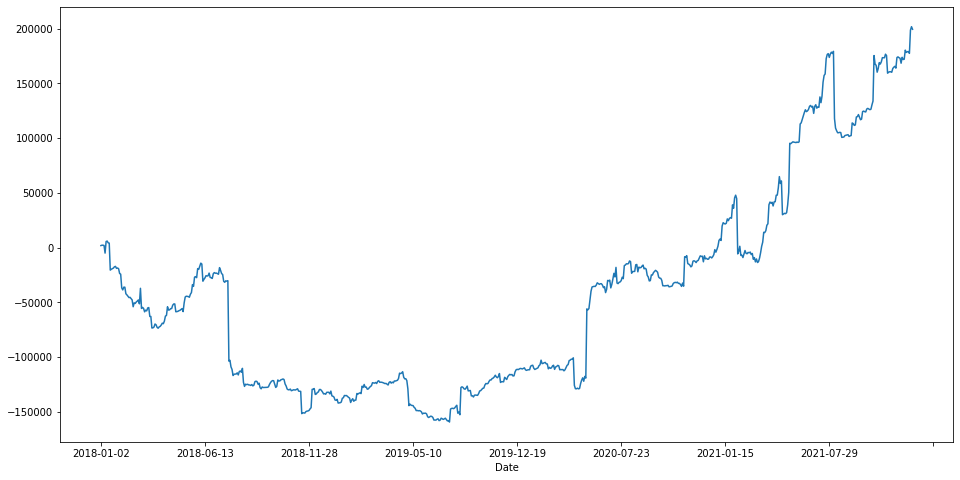

In [36]:
pd.DataFrame(pnl_cum).set_index('Date').PnL.cumsum().plot(figsize=(16,8))

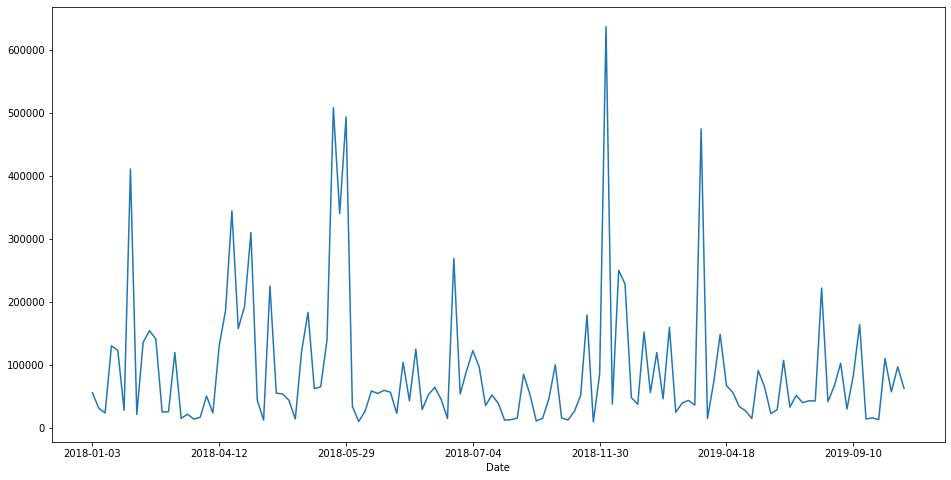

In [8]:
pd.DataFrame(pnl_cum).set_index('Date').TradeValue.plot(figsize=(16,8))

Date
2007-01-03       1
2007-01-04       2
2007-01-05       3
2007-01-08       6
2007-01-09       7
              ... 
2017-04-25    3766
2017-04-26    3767
2017-04-27    3768
2017-04-28    3769
2017-05-01    3772
Name: date_id, Length: 2600, dtype: int64


<AxesSubplot:xlabel='Date'>

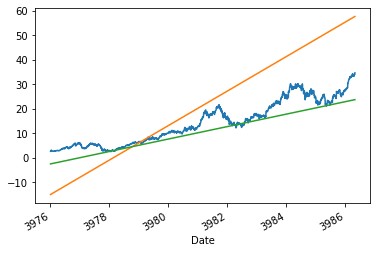

In [30]:
# import pandas as pd
# import quandl as qdl
from pandas_datareader import data as web
from scipy.stats import linregress

# get AAPL 10 years data

# data = qdl.get("WIKI/AAPL", start_date="2007-01-01", end_date="2017-05-01")
data = web.DataReader("AAPL",'yahoo',"2007-01-01", "2017-05-01")
# print(data)
data0 = data.copy()

data0['date_id'] = ((data0.index.date - data0.index.date.min())).astype('timedelta64[D]')
data0['date_id'] = data0['date_id'].dt.days + 1

# high trend line
print(data0['date_id'])
data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['High'],
                    )
    data1 = data1.loc[data1['High'] > reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['High'],
                    )

data0['high_trend'] = reg[0] * data0['date_id'] + reg[1]

# low trend line

data1 = data0.copy()

while len(data1)>3:

    reg = linregress(
                    x=data1['date_id'],
                    y=data1['Low'],
                    )
    data1 = data1.loc[data1['Low'] < reg[0] * data1['date_id'] + reg[1]]

reg = linregress(
                    x=data1['date_id'],
                    y=data1['Low'],
                    )

data0['low_trend'] = reg[0] * data0['date_id'] + reg[1]

# plot

data0['Adj Close'].plot()
data0['high_trend'].plot()
data0['low_trend'].plot()